In [1]:
import pandas as pd
import os

# Encontra diretorio atual
atual_dir = os.getcwd()

# Encontra csv das noticias
caminho_csv = os.path.join(atual_dir, "noticias_dados_limpos.csv")

# Lê o arquivo CSV em um DataFrame
df = pd.read_csv(caminho_csv)

In [2]:
df.head()

,Texto,Categoria
0,O Podemos decidiu expulsar o deputado federal ...,Real
1,"Bolsonaro é um liberal completo, diz president...",Real
2,Ministro do STF libera Andrea Neves de prisão ...,Real
3,"Apesar da abundância, cresce preocupação com p...",Real
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",Real


In [3]:
# Aplicação do LabelEncoder para transformar a variável categórica 'Categoria' em uma variável numérica 'label'.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['label'] = le.fit_transform(df['Categoria'])

In [4]:
df['Categoria'].unique(), df['label'].unique()

(array(['Real', 'Falso'], dtype=object), array([1, 0]))

In [5]:
df.drop(df.columns[1], axis=1, inplace=True)
df.head()

,Texto,label
0,O Podemos decidiu expulsar o deputado federal ...,1
1,"Bolsonaro é um liberal completo, diz president...",1
2,Ministro do STF libera Andrea Neves de prisão ...,1
3,"Apesar da abundância, cresce preocupação com p...",1
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",1


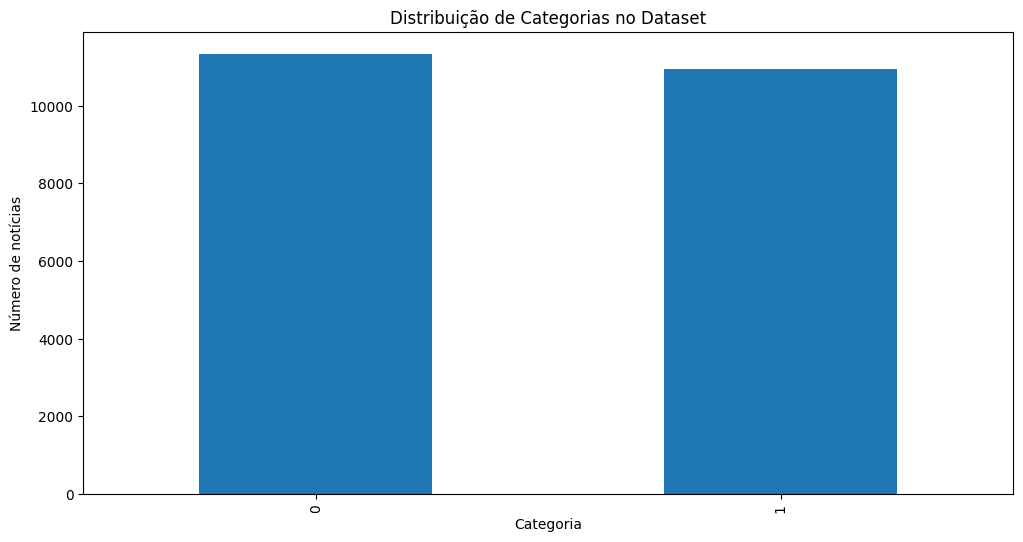

In [6]:
import matplotlib.pyplot as plt

contagem_categoria = df['label'].value_counts()

plt.figure(figsize=(12,6))
contagem_categoria.plot(kind='bar')
plt.xlabel('Categoria')
plt.ylabel('Número de notícias')
plt.title('Distribuição de Categorias no Dataset')
plt.show()

In [7]:
import string
import spacy
import unicodedata
from tqdm import tqdm
import numpy as np

# Habilita suporte do tqdm para os métodos de progressão do pandas (como progress_aplly)
tqdm.pandas()

# Carrega modelo de linguagem 'pt_core_news_lg' do spacy para processamento de texto em português
# Desabilita os componentes 'parser' e 'ner', já que não são necessários para a lematização
modelo_spacy_nlp = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocess_data(df, coluna_texto):
    """
    Realiza o pré-processamento dos dados de um texto em um Dataframe do Pandas.
    Remove pontuação, números e palavras comuns (stop words), converte para minúsculas, remove 
    acentos e símbolos diversos, e aplica lematização.
    """

    # Remove pontuação
    print("Removendo pontuação...")
    traducao = str.maketrans('', '', string.punctuation)
    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: x.translate(traducao))

    # Remove números
    print("Removendo números...")
    traducao = str.maketrans('', '', string.digits)
    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: x.translate(traducao))

    # Remove acentos e símbolos diversos
    print("Removendo acentos e símbolos diversos...")
    def remove_acentos_e_simbolos(text):
        try:
            # Normaliza a string para a forma NFKD e mantém apenas caracteres que não são diacríticos
            # nem combinam caracteres com diacríticos
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            # Se não for possível normalizar um caractere, retorna uma string vazia
            return ''
    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: remove_acentos_e_simbolos(x))
    
    # Converte para minúsculas
    print("Convertendo para minúsculas...")
    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: x.lower())

    # Lematização
    print("Computando Lematização...")
    def lematizar_texto(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a memória disponível no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em várias partes

    chunks_processados = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        chunk_processado = chunk.copy() # Cria uma cópia para realizar o processamento
        
        # Aplica a função 'lematizar_texto' a cada documento processado pelo spaCy (usando 'spacy_nlp_model.pipe') e
        # atribui os resultados (uma lista de palavras lematizadas) à coluna 'coluna_texto' do DataFrame 'chunks_processados'.
        # O tqdm é utilizado para exibir uma barra de progresso durante o processamento dos documentos.
        chunk_processado[coluna_texto] = [lematizar_texto(doc) for doc in tqdm(modelo_spacy_nlp.pipe(chunk[coluna_texto].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[coluna_texto]))]

        # Junta as partes em uma lista, para formar o dataframe final
        chunks_processados.append(chunk_processado)

    concatenated_df = pd.concat(chunks_processados) # Concatenar os DataFrames processados

    df[coluna_texto] = concatenated_df[coluna_texto] # Atribuir a coluna 'texto' processada de volta ao dataframe original
    
    # Remover tokens com espaços vazios
    print("Remover tokens com espaços vazios...")
    df['Texto'] = df['Texto'].progress_apply(lambda x: [token for token in x if token.strip()])


In [8]:
preprocess_data(df, 'Texto') # Realiza o pré-processamento

Removendo pontuação...


100%|██████████| 22284/22284 [00:02<00:00, 9140.29it/s] 


Removendo números...


100%|██████████| 22284/22284 [00:02<00:00, 9646.73it/s] 


Removendo acentos e símbolos diversos...


100%|██████████| 22284/22284 [00:08<00:00, 2746.70it/s]


Convertendo para minúsculas...


100%|██████████| 22284/22284 [00:00<00:00, 116060.82it/s]
c:\Users\mathe\OneDrive\Área de Trabalho\Detector\.venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 2229/2229 [01:58<00:00, 18.80it/s]


Processando segmento 2 de 10


100%|██████████| 2229/2229 [01:29<00:00, 24.85it/s] 


Processando segmento 3 de 10


100%|██████████| 2229/2229 [00:18<00:00, 118.02it/s]


Processando segmento 4 de 10


100%|██████████| 2229/2229 [00:17<00:00, 124.27it/s]


Processando segmento 5 de 10


100%|██████████| 2228/2228 [00:37<00:00, 60.13it/s] 


Processando segmento 6 de 10


100%|██████████| 2228/2228 [00:10<00:00, 208.50it/s]


Processando segmento 7 de 10


100%|██████████| 2228/2228 [00:10<00:00, 210.74it/s]


Processando segmento 8 de 10


100%|██████████| 2228/2228 [00:10<00:00, 208.01it/s]


Processando segmento 9 de 10


100%|██████████| 2228/2228 [00:10<00:00, 213.57it/s]


Processando segmento 10 de 10


100%|██████████| 2228/2228 [00:10<00:00, 214.42it/s]


Remover tokens com espaços vazios...


100%|██████████| 22284/22284 [00:00<00:00, 29510.85it/s]


In [9]:
# Salvar em formato pickle
df.to_pickle("noticias_pre_processadas_df.pkl")

In [10]:
df['Texto']

0        [poder, decidir, expulsar, deputado, federal, ...
1        [bolsonaro, liberal, completo, presidente, psl...
2        [ministro, stf, liberar, Andrea, Neves, prisao...
3        [apesar, abundancia, crescer, preocupacao, pre...
4        [harvard, mit, levarao, dilma, moro, suplicy, ...
                               ...                        
22279    [encontrar, reunir, presidente, jair, Bolsonar...
22280    [reabertura, complexo, parque, disney, orlar, ...
22281    [publicacao, circular, rede, social, pedir, mi...
22282    [juiz, Wauner, Batista, Ferreiro, machadar, va...
22283    [boato, –, apo, zombar, miss, cidade, Campo, p...
Name: Texto, Length: 22284, dtype: object